In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.image import imread
import os

In [2]:
print(tf.__version__)

2.3.0


In [3]:
current_dir = os.getcwd()
train_path = current_dir + "\\data\\train"
test_path = current_dir + "\\data\\test"

Check if all images in "train" are consistent in size.

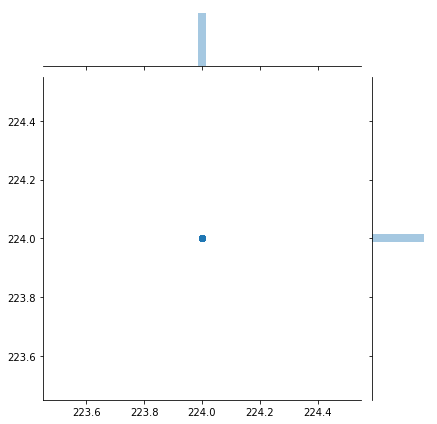

In [4]:
h_list = []
w_list = []

for image_name in os.listdir(train_path+"\\benign"):
    img = imread(train_path+"\\benign\\" + image_name)
    h,w,_ = img.shape
    h_list.append(h)
    w_list.append(w)

sns.jointplot(h_list,w_list)

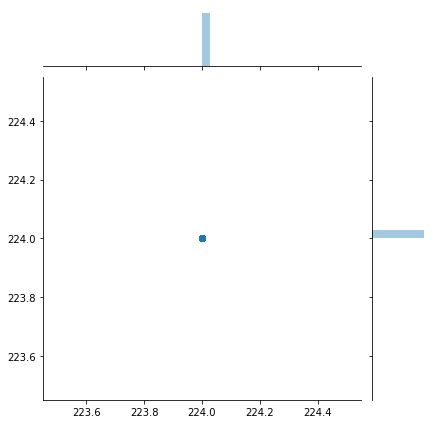

In [5]:
h_list = []
w_list = []

for image_name in os.listdir(train_path+"\\malignant"):
    img = imread(train_path+"\\malignant\\" + image_name)
    h,w,_ = img.shape
    h_list.append(h)
    w_list.append(w)

sns.jointplot(h_list,w_list)

All images in the train folder are consistent in size. Now we can go ahead and multiply images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
image_generator = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 90,
                                    width_shift_range = 0.15,
                                    height_shift_range = 0.15,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    zoom_range = (0.9,1),
                                    fill_mode = "nearest"
                                    )

Let's pick one image from the folder and see how the generator transforms it.

Text(0.5,1,'Transformed Image')

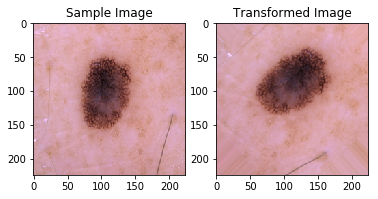

In [8]:
sample_img = imread(train_path + "\\benign\\" + os.listdir(train_path + "\\benign\\")[0])
transformed_img = image_generator.random_transform(sample_img)

fg, ax = plt.subplots(1,2)
ax[0].imshow(sample_img)
ax[0].set_title("Sample Image")
ax[1].imshow(transformed_img)
ax[1].set_title("Transformed Image")

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, MaxPool2D, Dropout, Flatten, Activation
from keras.layers import BatchNormalization

In [10]:
model = Sequential()

# add 3 convolutional layers
model.add(Conv2D(input_shape=(150,150,3), filters=32, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(input_shape=(73,73,32), filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(input_shape=(35,53,35), filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

#=> output should be (16,16,128). Now flatten the output
model.add(Flatten())

#classification stage
model.add(Dense(256,activation = 'relu'))
# remove Dropout for the best performance
# model.add(Dropout(rate = 0.1))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

EarlyStopping is deployed to monitor validation loss and halt the training at the right time.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode = "min", patience = 30)

ModelCheckPoint is deployed to monitor validation accuracy and save the best model with the highest validation accuracy.

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=current_dir + "\\best_acc_model.hdf5", 
                               monitor = 'val_accuracy',
                               mode='max',
                               verbose=0, 
                               save_best_only=True)

TensorBoard is deployed for hyperparameter tuning.

In [1]:
import datetime
from keras.callbacks import TensorBoard
%load_ext tensorboard

Confirm that Tensorflow is running on GPU.

In [15]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
def start_training(model, time):
    tensorboard = TensorBoard(log_dir="logs/{}".format(time))
    # steps_per_epoch = 2637 / 32 ~ 83 steps
    results = model.fit(x = image_generator.flow_from_directory(train_path,
                                                               target_size = (150,150),
                                                               class_mode = 'binary',
                                                                color_mode = 'rgb',
                                                                batch_size = 32,
                                                                ),
                       validation_data = image_generator.flow_from_directory(test_path,
                                                                       target_size = (150,150),
                                                                       class_mode = 'binary',
                                                                        color_mode = 'rgb',
                                                                        batch_size = 32,
                                                                        shuffle = False
                                                                       ),
                       epochs = 300,
                       verbose = 1,
                       callbacks = [early_stopping,checkpoint,tensorboard]
                       )
    return results

In [17]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S");

# decorate start_training with tf.autograph.experimental.do_not_convert to silence distracting warnings
tf.autograph.experimental.do_not_convert(
    func=start_training(model = model,time = current_time)
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/300
 1/83 [..............................] - ETA: 0s - loss: 0.6834 - accuracy: 0.5312WARNING:tensorflow:From C:\Users\huynh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
83/83 [==============================] - 36s 431ms/step - loss: 0.7319 - accuracy: 0.5647 - val_loss: 0.6717 - val_accuracy: 0.5697
Epoch 2/300
83/83 [==============================] - 30s 362ms/step - loss: 0.6729 - accuracy: 0.6064 - val_loss: 0.5350 - val_accuracy: 0.7242
Epoch 3/300
83/83 [==============================] - 32s 389ms/step - loss: 0.5168 - accuracy: 0.7410 - val_loss: 0.4776 - val_accuracy: 0.7424
Epoch 4/300
83/83 [==============================] - 31s 379ms/step - loss: 0.4770 - accuracy: 0.7565 -

83/83 [==============================] - 29s 346ms/step - loss: 0.2522 - accuracy: 0.8908 - val_loss: 0.3012 - val_accuracy: 0.8636
Epoch 109/300
83/83 [==============================] - 36s 432ms/step - loss: 0.2482 - accuracy: 0.8817 - val_loss: 0.3167 - val_accuracy: 0.8515
Epoch 110/300
83/83 [==============================] - 29s 348ms/step - loss: 0.2400 - accuracy: 0.8881 - val_loss: 0.3136 - val_accuracy: 0.8424
Epoch 111/300
83/83 [==============================] - 29s 346ms/step - loss: 0.2537 - accuracy: 0.8885 - val_loss: 0.3234 - val_accuracy: 0.8348
Epoch 112/300
83/83 [==============================] - 29s 344ms/step - loss: 0.2527 - accuracy: 0.8851 - val_loss: 0.3172 - val_accuracy: 0.8439
Epoch 113/300
83/83 [==============================] - 29s 347ms/step - loss: 0.2486 - accuracy: 0.8878 - val_loss: 0.2931 - val_accuracy: 0.8742
Epoch 114/300
83/83 [==============================] - 29s 347ms/step - loss: 0.2350 - accuracy: 0.8965 - val_loss: 0.2969 - val_accuracy:

<function tensorflow.python.autograph.impl.api.do_not_convert.<locals>.wrapper(*args, **kwargs)>

Tensorboard does not record metrics such as loss and accuracy for training and validation. Therefore, I add them manually to the tensorboard.

In [18]:
hist = pd.DataFrame(model.history.history)
train_loss = model.history.history['loss']
train_accuracy = model.history.history['accuracy']
val_loss = model.history.history['val_loss']
val_accuracy = model.history.history['val_accuracy']
log_dir = "logs/" + str(current_time) +"/"
log_dir_accuracy = log_dir + "accuracy"
log_dir_loss = log_dir + "loss"

In [19]:
train_log_dir_loss = log_dir_loss + "/train_loss"
test_log_dir_loss = log_dir_loss + "/validation_loss"
train_summary_writer = tf.summary.create_file_writer(train_log_dir_loss)
test_summary_writer = tf.summary.create_file_writer(test_log_dir_loss)
for epoch in range(len(train_loss)):
    with train_summary_writer.as_default():
        tf.summary.scalar(name='loss', data=train_loss[epoch], step=epoch+1)
    with test_summary_writer.as_default():   
        tf.summary.scalar(name='loss', data=val_loss[epoch], step=epoch+1)

In [20]:
train_log_dir_accuracy= log_dir_accuracy + "/train_accuracy"
test_log_dir_accuracy = log_dir_accuracy + "/validation_accuracy"
train_summary_writer = tf.summary.create_file_writer(train_log_dir_accuracy)
test_summary_writer = tf.summary.create_file_writer(test_log_dir_accuracy)
for epoch in range(len(train_accuracy)):
    with train_summary_writer.as_default():
        tf.summary.scalar(name='accuracy', data=train_accuracy[epoch], step=epoch+1)
    with test_summary_writer.as_default():   
        tf.summary.scalar(name='accuracy', data=val_accuracy[epoch], step=epoch+1)

In [7]:
%tensorboard --logdir=logs/ --port=5555

Reusing TensorBoard on port 5555 (pid 34140), started 0:02:04 ago. (Use '!kill 34140' to kill it.)

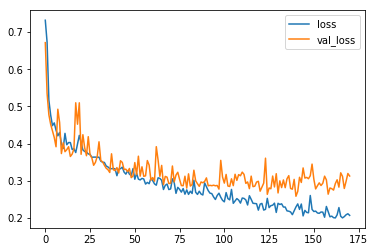

In [22]:
hist[['loss','val_loss']].plot()

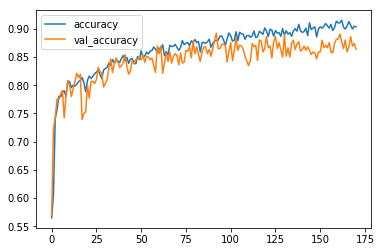

In [23]:
hist[['accuracy','val_accuracy']].plot()

Let's create a test set to test the model performance.

In [24]:
test_set_gen = image_generator.flow_from_directory(test_path,
                                                   target_size = (150,150),
                                                   class_mode = 'binary',
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    shuffle = False
                                                   )

Found 660 images belonging to 2 classes.


Now we run the model on the test set.

In [25]:
predictions = model.predict(test_set_gen)

Predictions with more than 50% will be classified as malignant; otherwise, benign.

In [26]:
predictions = predictions > 0.5

In [27]:
test_set_gen.class_indices

{'benign': 0, 'malignant': 1}

Perform evaluation with a classification report and a confusion matrix.

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print(classification_report(test_set_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       360
           1       0.85      0.83      0.84       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



In [30]:
print(confusion_matrix(test_set_gen.classes, predictions))

[[317  43]
 [ 50 250]]


In [31]:
model.save('model_NoDropOutImageGenTuning.h5')

In [32]:
from tensorflow.keras.models import load_model

In [77]:
high_accuracy_model = load_model(current_dir+"/best_acc_model.hdf5")

ModelCheckpoint saved the model at epoch 93 (val_accuracy = 0.8924). Let's see how the model performs.

In [78]:
predictions2 = high_accuracy_model.predict(test_set_gen)
predictions2 = predictions2 > 0.5

In [79]:
print(classification_report(test_set_gen.classes,predictions2))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       360
           1       0.88      0.87      0.87       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660



In [80]:
print(confusion_matrix(test_set_gen.classes, predictions2))

[[323  37]
 [ 40 260]]
